## This file is modified based on new understandings and methodologies since the original implementation (2 years later)

**The primary purpose of this study was to assess the rates of adolescent maternal mortality within Mexico, and calculate the risk probability of an adolescent maternal mortality by region in Mexico based on some of the top features contributing to maternal mortality.**

In [1]:
# Import the relevant modules
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
from matplotlib.colors import ListedColormap

# Machine Learning modules
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz
from sklearn.naive_bayes import GaussianNB

# Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

# Logistic Regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Hyperparameters
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score

# ROC Curve
from sklearn.metrics import roc_curve

# Scale Data
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [11]:
# Open merged materna_mortal_factors dataset
%store -r ml_adomaternal_mortality
data = ml_adomaternal_mortality
data.head(10)

,State,State Population 2015,Region (n),μ Age Variance,Equal or Above μ Age in Mexico,Region Mode Education Level,Education Definition,Most Common Region Local Community Size,Local Community Definition,Received Medical Assist
0,Aguascalientes,1044049,127.0,55.16,True,5.0,SECUNDARIA COMPLETA,15.0,500000 a 999999 habitantes,1.0
1,Baja California,3315766,361.0,46.31,False,5.0,SECUNDARIA COMPLETA,16.0,1000000 a 1499999 habitantes,1.0
4,Baja California Sur,272711,66.0,55.37,False,6.0,BACHILLERATO O PREPARATORIA COMPLETA,13.0,100000 a 249999 habitantes,1.0
5,Campeche,283025,126.0,44.29,False,5.0,SECUNDARIA COMPLETA,13.0,100000 a 249999 habitantes,1.0
6,Chiapas,1162592,310.0,45.02,False,5.0,SECUNDARIA COMPLETA,15.0,500000 a 999999 habitantes,1.0
8,Chihuahua,2616912,49.0,40.12,False,5.0,SECUNDARIA COMPLETA,13.0,100000 a 249999 habitantes,1.0
12,Coahuila de Zaragoza,2823877,1235.0,61.58,True,2.0,PRIMARIA INCOMPLETA,1.0,1 a 999 habitantes,1.0
16,Colima,512182,628.0,55.14,False,1.0,NINGUNA,1.0,1 a 999 habitantes,1.0
18,Durango,654876,263.0,57.71,True,5.0,SECUNDARIA COMPLETA,1.0,1 a 999 habitantes,1.0
19,Guanajuato,3250817,707.0,54.33,True,3.0,PRIMARIA COMPLETA,1.0,1 a 999 habitantes,1.0


In [12]:
string_data = data[['State','Education Definition','Local Community Definition']]

# Select non-categorical columns (since categorical columns are descriptors of numeric columns)
data = data.drop(columns=['Education Definition','Local Community Definition'])
data.head()

,State,State Population 2015,Region (n),μ Age Variance,Equal or Above μ Age in Mexico,Region Mode Education Level,Most Common Region Local Community Size,Received Medical Assist
0,Aguascalientes,1044049,127.0,55.16,True,5.0,15.0,1.0
1,Baja California,3315766,361.0,46.31,False,5.0,16.0,1.0
4,Baja California Sur,272711,66.0,55.37,False,6.0,13.0,1.0
5,Campeche,283025,126.0,44.29,False,5.0,13.0,1.0
6,Chiapas,1162592,310.0,45.02,False,5.0,15.0,1.0


### Dataset Target Variable: Above(0) or Below(1) MEX μ

## Assess potential correlation of various factors within each Region
- Create a correlation dataframe
- Plot the correlation dataframe on a sns heatmap:
    - Cells that are in green show positive correlation
    - Cells that are in red show negative correlation

<AxesSubplot:>

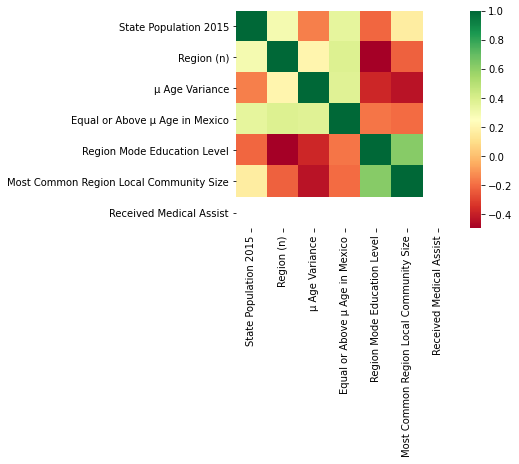

In [13]:
# Create a correlation dataframe
feature_corr = data.corr()

# Plot a correlation heatmap
sns.heatmap(feature_corr, square=True, cmap='RdYlGn')

In [14]:
data.corr()

,State Population 2015,Region (n),μ Age Variance,Equal or Above μ Age in Mexico,Region Mode Education Level,Most Common Region Local Community Size,Received Medical Assist
State Population 2015,1.000000,0.294634,-0.151977,0.346555,-0.210841,0.167483,NaN
Region (n),0.294634,1.000000,0.203397,0.381747,-0.493669,-0.221252,NaN
μ Age Variance,-0.151977,0.203397,1.000000,0.374289,-0.373848,-0.429609,NaN
Equal or Above μ Age in Mexico,0.346555,0.381747,0.374289,1.000000,-0.173205,-0.199854,NaN
Region Mode Education Level,-0.210841,-0.493669,-0.373848,-0.173205,1.000000,0.624954,NaN
Most Common Region Local Community Size,0.167483,-0.221252,-0.429609,-0.199854,0.624954,1.000000,NaN
Received Medical Assist,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Prepare Data for Logisitic Regression Machine Learning Model

#### Purpose for Changing all Categorical Strings to a Numeric Value: 
- Machine Learning models will ignore string values (strings have no statistical value unless added)
- Numeric values are comparable therefore string values should be categorically changed to numbers
- This is how you compare a string value to a numeric value that the model can use

In [16]:
# Convert Column value strings to a numeric value
for i, column in enumerate(list([str(d) for d in data.dtypes])):
    if column == "object":
        data[data.columns[i]] = data[data.columns[i]].fillna(data[data.columns[i]].mode())
        data[data.columns[i]] = data[data.columns[i]].astype("category").cat.codes
    else:
        data[data.columns[i]] = data[data.columns[i]].fillna(data[data.columns[i]].median())

In [17]:
data.head()

,State,State Population 2015,Region (n),μ Age Variance,Equal or Above μ Age in Mexico,Region Mode Education Level,Most Common Region Local Community Size,Received Medical Assist
0,0,1044049,127.0,55.16,True,5.0,15.0,1.0
1,1,3315766,361.0,46.31,False,5.0,16.0,1.0
4,2,272711,66.0,55.37,False,6.0,13.0,1.0
5,3,283025,126.0,44.29,False,5.0,13.0,1.0
6,4,1162592,310.0,45.02,False,5.0,15.0,1.0


# Basic Logistic Regression: 
* **Target Variable: Above(0)/Not(1) MeEX μ *(age maternal mortality)***
* Split the data into a training and test (hold-out) set
* Train on the training set, and test for accuracy on the testing set

In [18]:
# Create a Logistic Regression Incidence 
clf_log = LogisticRegression(random_state=42, solver='lbfgs')

#### Test-Train-Split:
- X = copy of all features and the response variable of dataset
- y = all features within dataset *excluding the response (target) variable*
- test_size = represents the proportion of the dataset (as a percentage) to include in the test split
- random_state = the seed used by the random number generator

In [20]:
# Entire dataset (even with response variable)
X = data.copy()

# The response variable
y = data.copy().pop('Equal or Above μ Age in Mexico')

In [21]:
list(X.columns)

['State',
 'State Population 2015',
 'Region (n)',
 'μ Age Variance',
 'Equal or Above μ Age in Mexico',
 'Region Mode Education Level',
 'Most Common Region Local Community Size',
 'Received Medical Assist']

In [22]:
# Create train and test data sets with train_test_split
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.3, random_state=42)
len(X_train), len(X_test), len(y_train), len(y_test)

(19, 9, 19, 9)

# Round 1: Unscaled Data

#### Random Forest Classifier: Visualize Data and Determine How Features Interact

In [23]:
# Create a Random Forest Classifier Incidence 
rfc = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)

#### Random Forest Classifier with Unscaled Data

In [24]:
# Fit rfc to training data (unscaled)
rfc_unscaled = rfc.fit(X_train, y_train)
rfc_unscaled

RandomForestClassifier(max_depth=2, random_state=0)

In [25]:
# Weighted importances of the variables
{X.columns[i]: weight for i, weight in enumerate(rfc_unscaled.feature_importances_)}

{'State': 0.08010155485969317,
 'State Population 2015': 0.12369741492978903,
 'Region (n)': 0.24745175585582743,
 'μ Age Variance': 0.08127292133441796,
 'Equal or Above μ Age in Mexico': 0.2953308793309139,
 'Region Mode Education Level': 0.09628061416966606,
 'Most Common Region Local Community Size': 0.07586485951969243,
 'Received Medical Assist': 0.0}

In [26]:
# let's take a look at the results
feature_imp = pd.DataFrame(list(zip(X.columns, rfc_unscaled.feature_importances_)), columns=['features', 'coeffs'])
feature_imp=feature_imp.set_index('features')
feature_imp=feature_imp.sort_values('coeffs')
feature_imp

,coeffs
features,
Received Medical Assist,0.000000
Most Common Region Local Community Size,0.075865
State,0.080102
μ Age Variance,0.081273
Region Mode Education Level,0.096281
State Population 2015,0.123697
Region (n),0.247452
Equal or Above μ Age in Mexico,0.295331


<AxesSubplot:xlabel='features'>

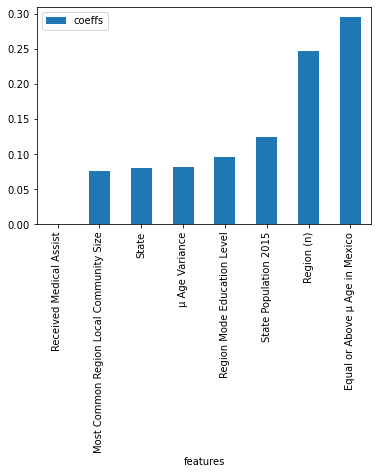

In [27]:
feature_imp.plot(kind='bar')

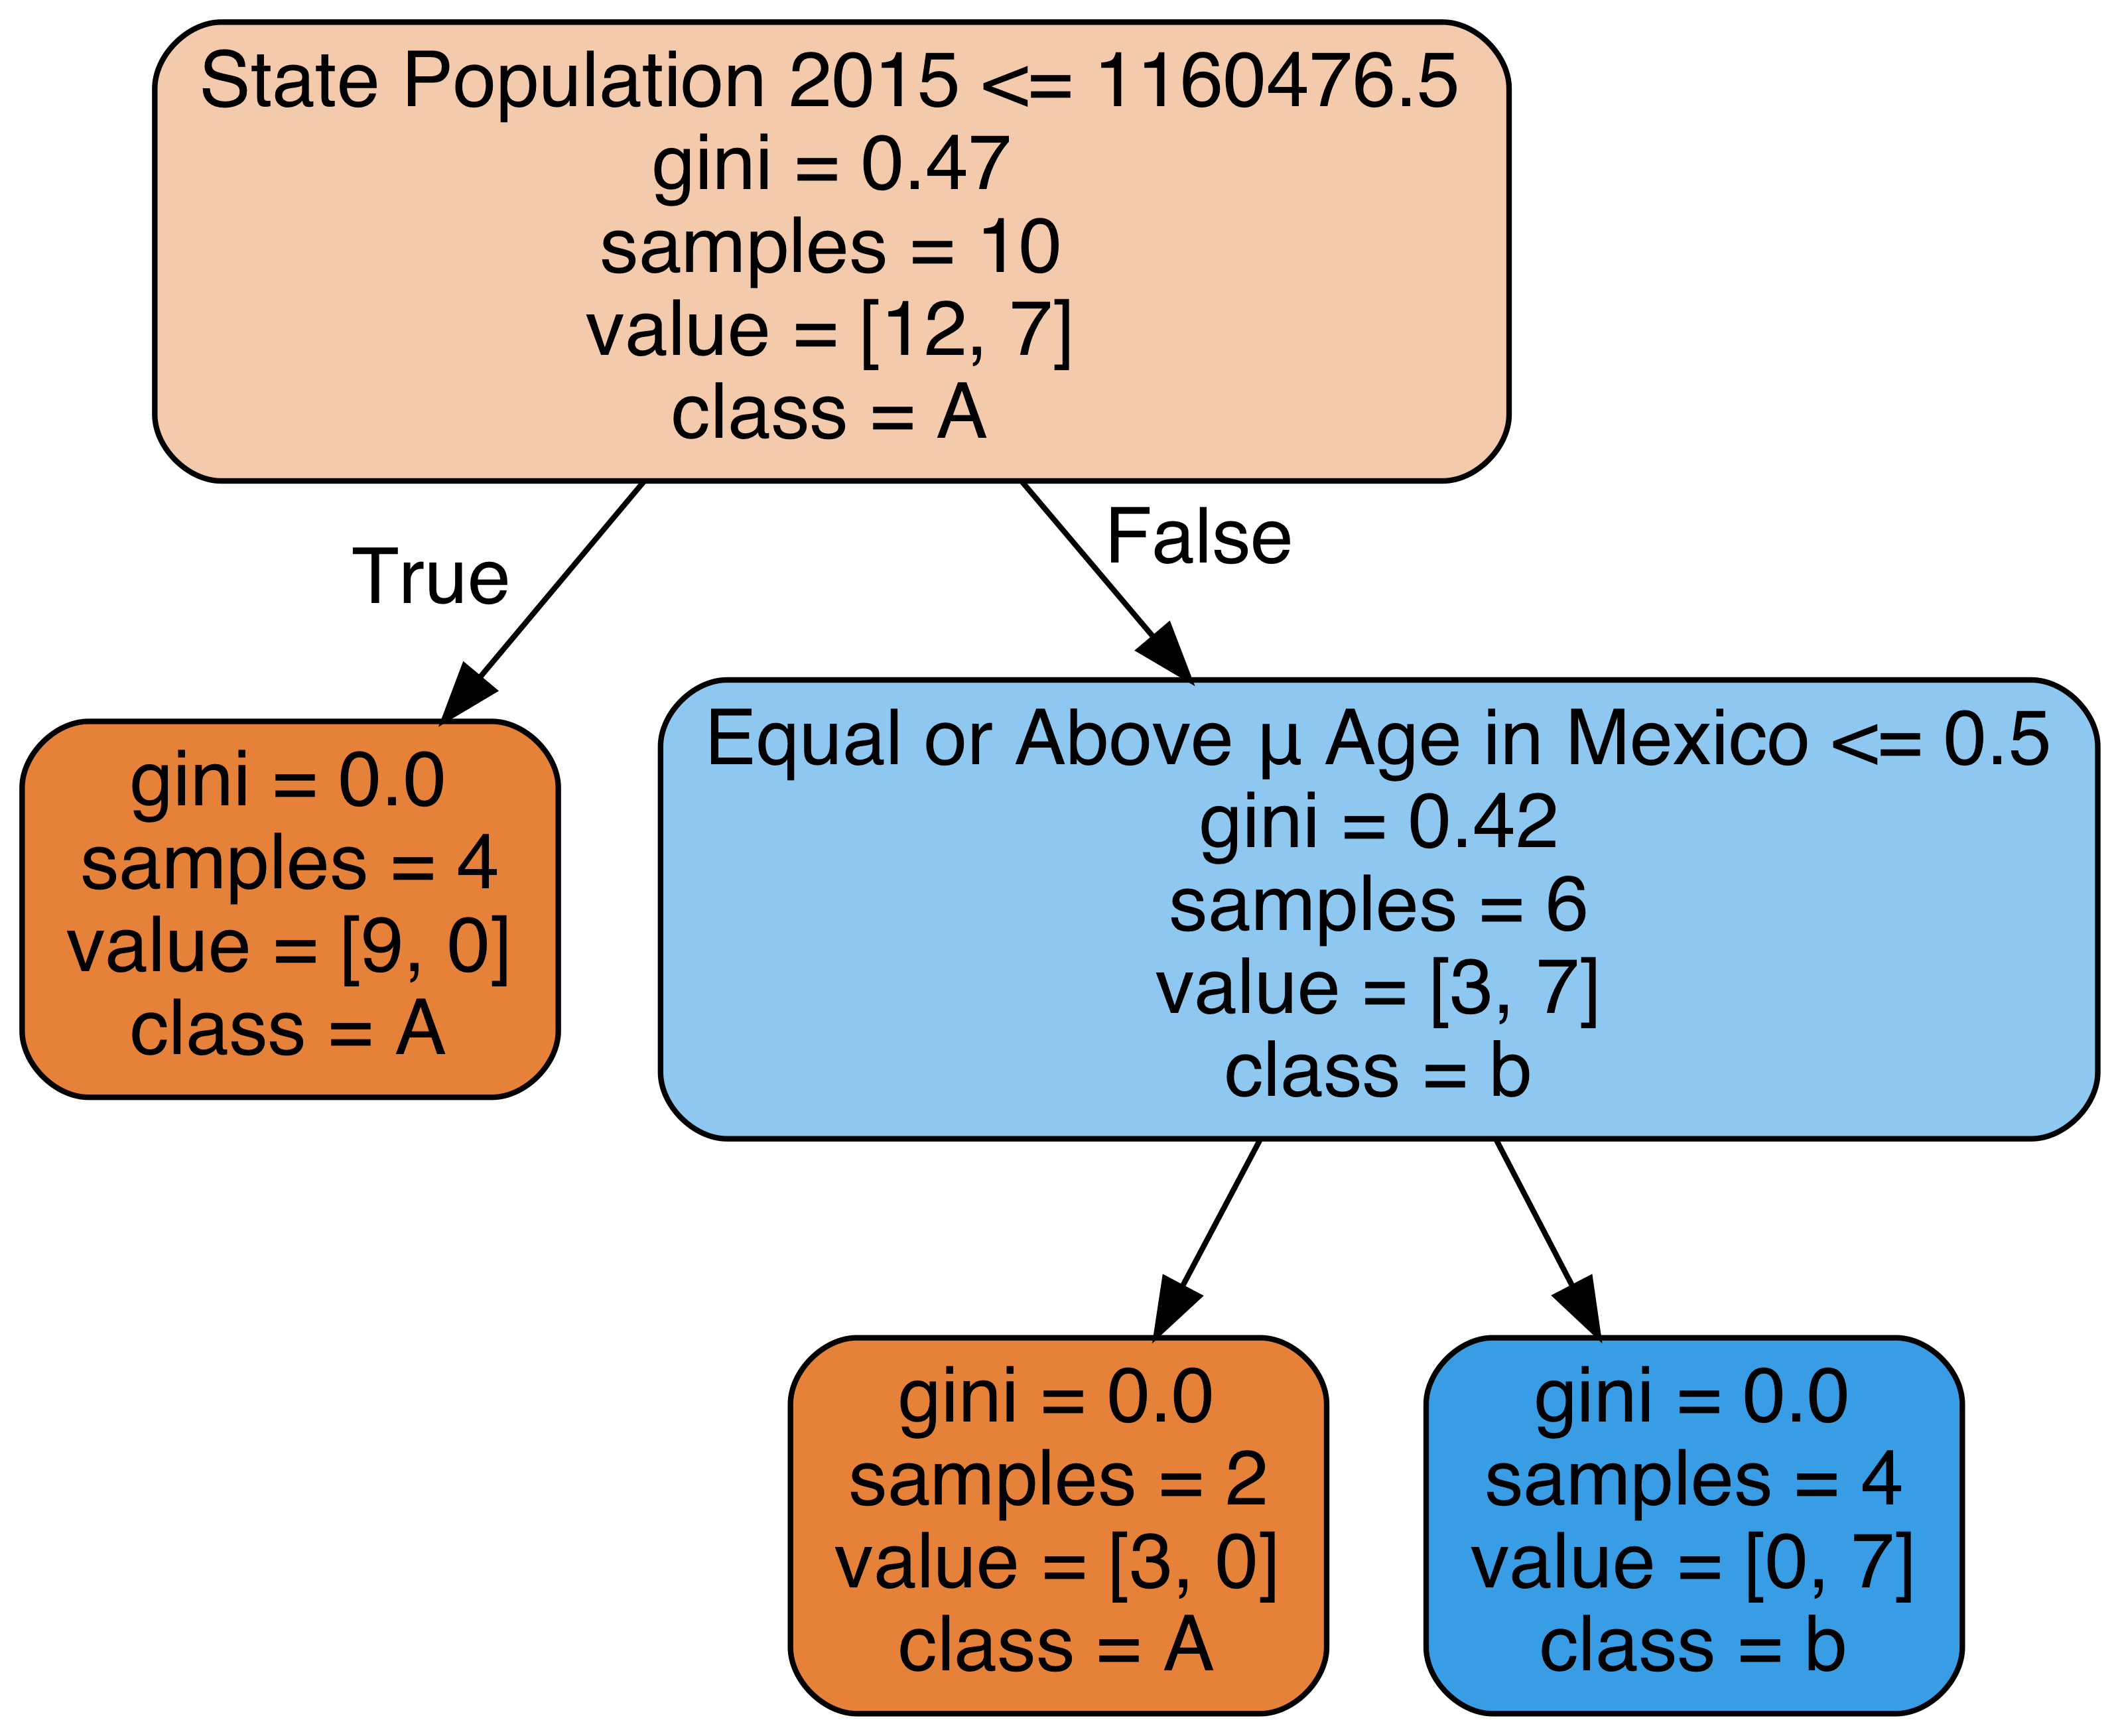

In [28]:
# Extract single tree
estimator = rfc_unscaled.estimators_[5]

from sklearn.tree import export_graphviz

# Export as dot file
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = X.columns,
                class_names = 'Above(0)/Not(1) Mexico μ Age Maternal Mortality',
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

*Observations*: It appears that the primary feature that predicts the target variable are State Population (2015), however, this may be due to the lack of datapoint within each feature. The unscaled dataset will be assessed first, but increased model accuracy will most likely be obtainable by scaling the data. 

#### Logistic Regression with Unscaled Data

In [29]:
# Fit clf_log to training data (unscaled)
clf_log_unscaled = clf_log.fit(X_train, y_train)

In [30]:
# Examine the coefficients -each parameter has an effect on the target variable result
list(np.transpose(clf_log_unscaled.coef_))

[array([-1.46347001e-05]),
 array([-3.34478919e-07]),
 array([0.0019011]),
 array([-0.00010843]),
 array([3.93733846e-06]),
 array([-1.57324781e-05]),
 array([-4.53907581e-05]),
 array([-2.49918731e-06])]

In [31]:
# Calculate the class probablity -returns the probability of model's ability to predict a likely value of the features
probability = clf_log_unscaled.predict_proba(X_test)
probability

array([[0.4376674 , 0.5623326 ],
       [0.25922309, 0.74077691],
       [0.43181533, 0.56818467],
       [0.46904159, 0.53095841],
       [0.52859717, 0.47140283],
       [0.57881167, 0.42118833],
       [0.7233064 , 0.2766936 ],
       [0.42120533, 0.57879467],
       [0.38695368, 0.61304632]])

In [32]:
# Predict the model -assess how well the model predicts unseen data
predict = clf_log_unscaled.predict(X_test)

# Compute classification report (https://en.wikipedia.org/wiki/Precision_and_recall)

class_report = classification_report(y_test, predict)
print(class_report)

              precision    recall  f1-score   support

       False       0.00      0.00      0.00         3
        True       0.50      0.50      0.50         6

    accuracy                           0.33         9
   macro avg       0.25      0.25      0.25         9
weighted avg       0.33      0.33      0.33         9



#### Classification Report
- **Precision**: 
    - positive predictive value
    - total number predicted correctly
- **Recall**: 
    - model sensitivity 
    - the fraction of the relevant documents that are successfully retrieved
- **F1-score**:
    - single measurement of system
    - provide a single measurement for a system

**Classification Report Conclusion for Unscaled Data**: The Logistic Regression model produced a 0% percision, recall, and F1-score for all instances of '1' for the target variable, 'Above(0)/Not(1) MEX μ' *(age maternal mortality)* while producing a 57% percision, 80% recall, and 67% F1-score for instances of '0' for the target variable. This means that the model, while marginally accurate for detecting Regions with a μ Age Maternal Mortality that is above the μ Age Maternal Mortality in Mexico, is not a fully-encompassing model since it cannot accurately detect the when a region is below the country mean.

[[0 3]
 [3 3]]


<AxesSubplot:>

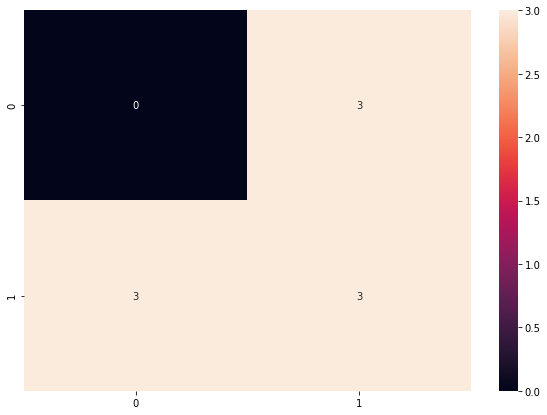

In [33]:
# Compute the confusion_matrix to evaluate the accuracy of a classification
conf_matrix = confusion_matrix(y_test, predict)
print(conf_matrix)

# Plot confusion_matrix
plt.figure(figsize = (10,7))
sns.heatmap(conf_matrix, annot=True)

In [34]:
# Print the accuracy from the testing data
'The accuracy score the the unscaled data is: ', accuracy_score(y_test, predict)

('The accuracy score the the unscaled data is: ', 0.3333333333333333)

In [35]:
# Compute predicted probabilities: y_pred_prob
y_pred_prob = clf_log_unscaled.predict_proba(X_test)[:,1]

# Compute and print AUC score
print("AUC: {}".format(roc_auc_score(y_test, y_pred_prob)))

# Compute cross-validated AUC scores: cv_auc
cv_auc = cross_val_score(clf_log, X, y, scoring='roc_auc', cv=5)

# Print list of AUC scores
print("AUC scores computed using 5-fold cross-validation: {}".format(cv_auc))

AUC: 0.22222222222222224
AUC scores computed using 5-fold cross-validation: [0.77777778 0.66666667 0.88888889 0.33333333 0.33333333]


#### Visualize Logistic Regression Model Accuracy with ROC curve

Text(0.5, 1.0, 'ROC Curve')

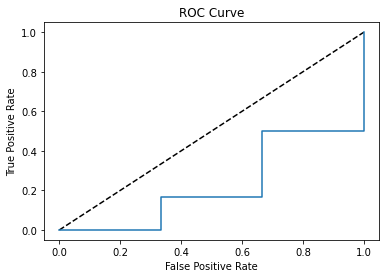

In [36]:
# Compute predicted probabilities: y_pred_prob
y_pred_prob = clf_log_unscaled.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')

## Tuning the Model
As stated above, this dataset is skewed in terms of number prediction (ie. cannot predict case 1 but can predict case 0). Most likely, this problem is due to the small size of the dataset; therefore, the same mechanism will be repeated as above but with scaled data.

# Round 2: Scaled Data

#### Scale Data for Logistic Regression with Standard Scaler and Pipeline

In [37]:
# Setup the pipeline steps: steps
steps = [('scaler', StandardScaler()),
        ('log', LogisticRegression(random_state=42, solver='lbfgs'))]
        
# Create the pipeline: pipeline
pipeline = Pipeline(steps)

#### Logistic Regression with Scaled Data

In [38]:
# Fit the pipeline to the training set: clf_log_scaled
clf_log_scaled = pipeline.fit(X_train, y_train)
clf_log_scaled

Pipeline(steps=[('scaler', StandardScaler()),
                ('log', LogisticRegression(random_state=42))])

In [39]:
# Calculate the class probablity -returns the probability of model's ability to predict a likely value of the features
probability = clf_log_scaled.predict_proba(X_test)
probability

array([[0.05902853, 0.94097147],
       [0.30916257, 0.69083743],
       [0.24352305, 0.75647695],
       [0.91764454, 0.08235546],
       [0.4426722 , 0.5573278 ],
       [0.04217784, 0.95782216],
       [0.07358132, 0.92641868],
       [0.89263138, 0.10736862],
       [0.20925078, 0.79074922]])

In [47]:
# let's take a look at the results
feature_imp2 = pd.DataFrame(list(zip(X.columns, clf_log_scaled.feature_importances_)), columns=['features', 'coeffs'])
feature_imp2=feature_imp.set_index('features')
feature_imp2=feature_imp.sort_values('coeffs')

AttributeError: 'Pipeline' object has no attribute 'best_estimator_'

In [40]:
# Predict the model -assess how well the model predicts unseen data
predict_scaled = clf_log_scaled.predict(X_test)

# Compute classification report (https://en.wikipedia.org/wiki/Precision_and_recall)

class_report = classification_report(y_test, predict_scaled)
print(class_report)

              precision    recall  f1-score   support

       False       1.00      0.67      0.80         3
        True       0.86      1.00      0.92         6

    accuracy                           0.89         9
   macro avg       0.93      0.83      0.86         9
weighted avg       0.90      0.89      0.88         9



**Classification Report Conclusion for Scaled Data**: The Logistic Regression model produced a 100% percision, 67% recall, and 80% F1-score for all instances of '1', and a 83% percision, 100% recall, and 91% F1-score for all instances of '0' of the target variable. This means that the model appears to identify Regions with a μ Age Maternal Mortality that *is* or *is not* above the μ Age Maternal Mortality in Mexico with marginal to somewhat reliable accuracy.

[[2 1]
 [0 6]]


<AxesSubplot:>

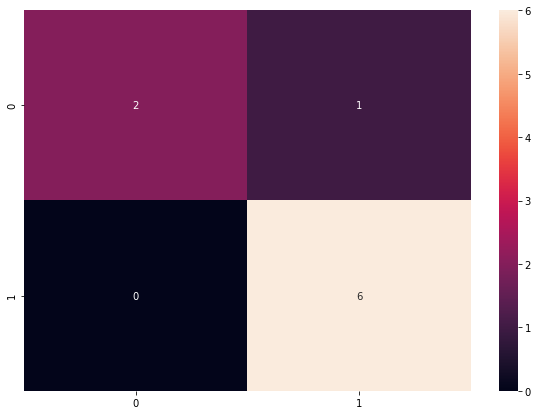

In [41]:
# Compute the confusion_matrix to evaluate the accuracy of a classification
conf_matrix = confusion_matrix(y_test, predict_scaled)
print(conf_matrix)

# Plot confusion_matrix
plt.figure(figsize = (10,7))
sns.heatmap(conf_matrix, annot=True)

In [42]:
# Print the accuracy from the testing data
'The accuracy score the the scaled data is: ', accuracy_score(y_test, predict_scaled)

('The accuracy score the the scaled data is: ', 0.8888888888888888)

In [43]:
# Compute predicted probabilities: y_pred_prob
y_pred_prob_scaled = clf_log_scaled.predict_proba(X_test)[:,1]

# Compute and print AUC score
print("AUC: {}".format(roc_auc_score(y_test, y_pred_prob_scaled)))

# Compute cross-validated AUC scores: cv_auc
cv_auc = cross_val_score(clf_log_scaled, X, y, scoring='roc_auc', cv=5)

# Print list of AUC scores
print("AUC scores computed using 5-fold cross-validation: {}".format(cv_auc))

AUC: 0.9444444444444445
AUC scores computed using 5-fold cross-validation: [1. 1. 1. 1. 1.]


#### Visualize Logistic Regression Model Accuracy for the Scaled Data with ROC curve

Text(0.5, 1.0, 'ROC Curve')

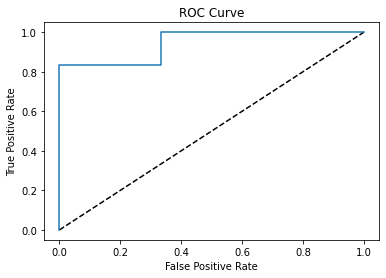

In [44]:
# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_scaled)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')

#### Visualize our true vs. predicted values

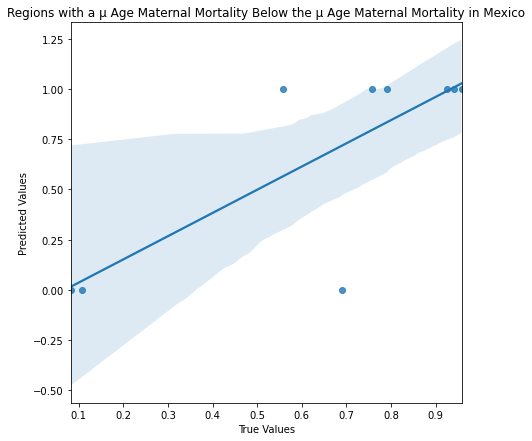

In [45]:
plt.figure(figsize=(7,7))
plt.title('Regions with a μ Age Maternal Mortality Below the μ Age Maternal Mortality in Mexico')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
fig=sns.regplot(x=y_pred_prob_scaled, y=y_test)
plt.show(fig)